In [1]:
import pandas as pd

from functions import *

Apply the already trained Word2Vec model from Google News dataset that contains about 100 billion words.
There's possibility to train our own model on our own data but the results might be worse.

Load googles w2v model if it's already downloaded and saved. Otherwise download it and save it.
Should be saved in default directory.

In [2]:
w2v = load_and_or_save_googles_w2v_model("w2v-gensim-model")
# try_googles_w2v_model(w2v)

Short display of the data.

In [3]:
DF = pd.read_csv("philosophy_data.csv")

DF["NumOfWords"]=DF["sentence_str"].apply(lambda x: len(x.split(" ")))
# print(DF.head())
print(DF['tokenized_txt'][0])
print(len(DF))

['what', 'new', 'socrates', 'to', 'make', 'you', 'leave', 'your', 'usual', 'haunts', 'in', 'the', 'lyceum', 'and', 'spend', 'your', 'time', 'here', 'by', 'the', 'king', 'archon', 'court']
360808


Cleanup some empty rows in tokenized column, and reset the indexing in the dataframe.

In [4]:
#Remove rows in the dataframe that are empty
remove_empty_rows(DF)
#Reset index of dataframe when removing rows.
DF.reset_index(drop = True, inplace = True)
print(len(DF))

360796


Extract the tokenized_txt DF["tokenized_txt"] sentences and append them into a python list.

In [5]:
sentences = []
collect_sentences_from_tokenized_txt(sentences, DF["tokenized_txt"])
sentences[:5]

["['what', 'new', 'socrates', 'to', 'make', 'you', 'leave', 'your', 'usual', 'haunts', 'in', 'the', 'lyceum', 'and', 'spend', 'your', 'time', 'here', 'by', 'the', 'king', 'archon', 'court']",
 "['surely', 'you', 'are', 'not', 'prosecuting', 'anyone', 'before', 'the', 'king', 'archon', 'as', 'am']",
 "['the', 'athenians', 'do', 'not', 'call', 'this', 'prosecution', 'but', 'an', 'indictment', 'euthyphro']",
 "['what', 'is', 'this', 'you', 'say']",
 "['someone', 'must', 'have', 'indicted', 'you', 'for', 'you', 'are', 'not', 'going', 'to', 'tell', 'me', 'that', 'you', 'have', 'indicted', 'someone', 'else']"]

The sentence_vectorizer function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to be able to get whole sentences vectorized values instead of individual words.
Using the function with our model (in this case w2v) sentences.

In [6]:
sentences_vectorized = []
for index, sentence in enumerate(sentences):
    temp_variable = sentence_vectorizer(sentence, w2v)
    #Check if np.array is empty
    sentences_vectorized.append(temp_variable)
    if index % 50000 == 0:
        print(index)


0
50000
100000
150000
200000
250000
300000
350000


Fetch the number of unique School of Thoughts.

In [7]:
schools = DF["school"].unique().tolist()
print(schools)
num_clusters = len(schools)


['plato', 'aristotle', 'empiricism', 'rationalism', 'analytic', 'continental', 'phenomenology', 'german_idealism', 'communism', 'capitalism', 'stoicism', 'nietzsche', 'feminism']


Bar plot how many sentences are from each School of Thought.
(Show the total amount of real assigned SOT on each text.)

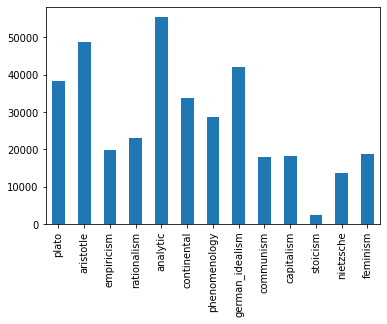

In [8]:
total_dict = dict.fromkeys(schools, 0)
for school in DF['school']:
    total_dict[school] += 1

plot_total_dict = pd.Series(total_dict)
plot_total_dict.plot(kind="bar")
plt.show()

Apply kmeans with num_clusters=amount of unique schools in the DF.

In [9]:
start = time.time()

kmeans, labels, centroids = apply_kmeans(num_clusters, sentences_vectorized)

end = time.time()
print(end - start)

264.1838753223419


In [10]:
start = time.time()

silhouette_score = metrics.silhouette_score(sentences_vectorized, labels, metric='euclidean')
print(silhouette_score)

end = time.time()
print(end - start)

0.026615586
4576.487424135208


Summarize the amount each cluster was assigned to a sentence.

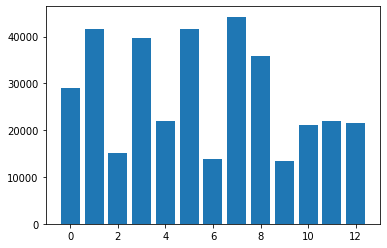

In [11]:
label_dict = dict.fromkeys(list(set(labels)), 0)
for cluster in labels:
    label_dict[cluster] += 1

plt.bar(range(len(label_dict)), label_dict.values())
plt.show()

Apply scatter plot on kmeans results using TSNE.

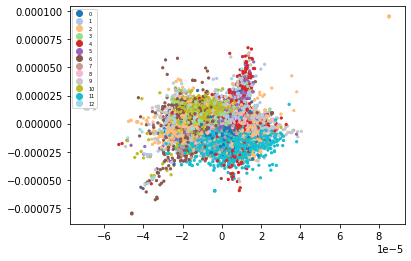

6378.271554946899


In [12]:
start = time.time()

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

unique_labels_list = list(set(labels))
Y=model.fit_transform(sentences_vectorized)

scatter = plt.scatter(Y[:,0], Y[:,1], c=labels, s=5, cmap='tab20')
plt.legend(handles=scatter.legend_elements()[0], labels=unique_labels_list, prop={"size":5})

#If we want to have centroids join the plot aswell.
# center=model.fit_transform(centroids)
# plt.scatter(CENTER[:,0], CENTER[:,1], c='black', s=10)
# for j in range(len(centroids)):
#     plt.annotate(unique_labels_list[j], xy=(CENTER[j][0], CENTER[j][1]), xytext=(0,0), textcoords='offset points')

plt.show()

end = time.time()
print(end - start)

Combine the kmeans clustering results with the labels.
Put the kmeans result in a dictionary:

{'plato': {0: 2262, 1: 2999, 2: 1715, 3: 4527, 4: 2552, 5: 2233, 6: 3139, 7: 4388, 8: 5128, 9: 1941, 10: 2645, 11: 2726, 12: 2111}, 'aristotle': {0: 4317, 1: 4098, 2: 2209, 3: 5506, 4: 2609, 5: 5781, 6: 1229, 7: 7197, 8: 5194, 9: 1779, 10: 2206, 11: 3912, 12: 2738}, 'empiricism': {0: 1739, 1: 2360, 2: 741, 3: 2895, 4: 999, 5: 2290, 6: 565, 7: 2886, 8: 1902, 9: 406, 10: 1194, 11: 882, 12: 1072}, 'rationalism': {0: 1950, 1: 2390, 2: 971, 3: 2630, 4: 1200, 5: 2468, 6: 743, 7: 3224, 8: 2684, 9: 644, 10: 1445, 11: 1359, 12: 1241}, 'analytic': {0: 5086, 1: 6269, 2: 2938, 3: 5290, 4: 3859, 5: 5282, 6: 2530, 7: 5367, 8: 4802, 9: 2574, 10: 3546, 11: 3769, 12: 4106}, 'continental': {0: 2947, 1: 4423, 2: 1349, 3: 3337, 4: 2026, 5: 5283, 6: 736, 7: 4354, 8: 2921, 9: 991, 10: 1513, 11: 1754, 12: 2145}, 'phenomenology': {0: 2468, 1: 3763, 2: 1088, 3: 2721, 4: 2318, 5: 4380, 6: 742, 7: 2631, 8: 2219, 9: 1258, 10: 1347, 11: 1532, 12: 2106}, 'german_idealism': {0: 3302, 1: 5039, 2: 1084, 3: 3446, 4: 29

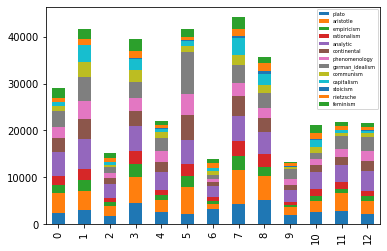

In [13]:
#Must find a way to assign each cluster to each school. This way is not optimal and doesn't result in a good assignment (but it's something).

#How many times cluster n was assigned to specific SOT
amount_SOT_got_clustered_dict = dict()
for i, school in enumerate(DF["school"]):
    if amount_SOT_got_clustered_dict.get(school) is None:
        amount_SOT_got_clustered_dict[school] = dict.fromkeys([i for i in range(len(schools))], 0)
    amount_SOT_got_clustered_dict[school][labels[i]] += 1

print(amount_SOT_got_clustered_dict)

cluster_n_assigned_to_SOT = pd.DataFrame(amount_SOT_got_clustered_dict)
cluster_n_assigned_to_SOT.plot(kind="bar", stacked=True)
plt.legend(prop={"size":5})
plt.show()


Make a list and convert all "plato" to 0 and "aristotele" to 1, etc.
This can then be applied with the predicted labels.


In [14]:
original_labels = [schools.index(school) for school in DF["school"]]

Apply v-measure. Print out dataframe.

In [17]:
print(v_measure_score(original_labels, labels))
pd.DataFrame(list(zip(original_labels, labels)), columns=["Original", "Predicted"])

0.015090540073222388


,Original,Predicted
0,0,3
1,0,3
2,0,8
3,0,9
4,0,3
...,...,...
360791,12,1
360792,12,5
360793,12,3
360794,12,1
